# 可视化类激活的热力图

In [1]:
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet')

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [5]:
img_path = 'creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x.shape

(224, 224, 3)

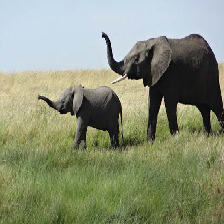

In [6]:
img

In [7]:
x = np.expand_dims(x, axis=0)
x.shape

(1, 224, 224, 3)

In [8]:
x = preprocess_input(x)
x.shape

(1, 224, 224, 3)

In [9]:
preds = model.predict(x)

In [10]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.86371523), ('n01871265', 'tusker', 0.12614334), ('n02504013', 'Indian_elephant', 0.009944004)]


In [11]:
decode_predictions(preds, top=3)

[[('n02504458', 'African_elephant', 0.86371523),
  ('n01871265', 'tusker', 0.12614334),
  ('n02504013', 'Indian_elephant', 0.009944004)]]

In [12]:
np.argmax(preds[0])

386

# Grad-CAM算法

In [26]:
african_elephant_output = model.output[:, 386]
african_elephant_output

<tf.Tensor 'strided_slice_2:0' shape=(?,) dtype=float32>

In [27]:
last_conv_layer = model.get_layer('block5_conv3')

In [28]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
grads

<tf.Tensor 'gradients_1/block5_pool/MaxPool_grad/MaxPoolGrad:0' shape=(?, 14, 14, 512) dtype=float32>

In [29]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))
pooled_grads

<tf.Tensor 'Mean_1:0' shape=(512,) dtype=float32>

In [30]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [31]:
pooled_grads_value, conv_layer_output_value = iterate([x])
pooled_grads_value

array([ 3.05920707e-06, -1.32316234e-06,  7.53554423e-06,  1.51378094e-06,
       -4.32488923e-06, -6.78134711e-06, -3.64252770e-07,  4.49880645e-06,
       -3.16793120e-07,  7.95331380e-06, -5.55566294e-06,  7.69614235e-06,
       -4.98045574e-06, -1.79578069e-06, -1.26045279e-07,  3.96626638e-06,
       -8.56426504e-06,  1.40377756e-06, -2.89103400e-06,  3.29205272e-06,
       -4.20617243e-06, -8.61405260e-06,  3.68772976e-06, -3.87306909e-06,
       -1.64932942e-06, -4.37860820e-07, -4.82873611e-06,  8.59800730e-06,
       -8.46496505e-07, -4.87112538e-06, -6.48070363e-06,  4.91755327e-06,
        6.22968901e-06, -2.18970186e-07,  7.45783564e-06, -9.86109080e-06,
        4.82074211e-06, -4.27754685e-06, -9.23147400e-06,  9.08999391e-06,
        8.91095567e-07, -5.58576858e-06,  8.19698471e-07,  1.16458350e-05,
       -4.44510442e-06,  2.18258140e-08,  7.31710679e-06, -6.24855420e-06,
       -7.82673305e-06, -4.84386646e-06, -5.74326259e-06,  2.49876371e-06,
        5.70320026e-06, -

In [32]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [33]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

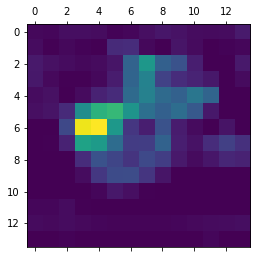

In [34]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [35]:
heatmap.shape

(14, 14)

In [36]:
import cv2

In [37]:
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

In [24]:
np.uint8(1.0)

1

In [ ]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

In [38]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
iterate_1 = K.function([model.input], [grads])
grads_value = iterate_1([x])
grads_value

[array([[[[ 2.6159800e-05, -2.4289613e-05,  3.8982686e-05, ...,
           -3.2006323e-05,  3.8723148e-05,  1.0706722e-05],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          [ 2.6529626e-05, -1.4610800e-05,  1.2289336e-05, ...,
           -7.0416113e-06,  5.2637210e-05,  1.0692782e-05],
          ...,
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          [ 4.8595117e-05, -1.8795457e-05,  3.2824963e-05, ...,
           -3.5809266e-05, -4.5068573e-06,  1.6272354e-06],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],
 
         [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000

In [39]:
grads_value[0].shape

(1, 14, 14, 512)

In [40]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate_2 = K.function([model.input], [pooled_grads])
pooled_grads_value = iterate_2([x])
pooled_grads_value

[array([ 3.05920707e-06, -1.32316234e-06,  7.53554423e-06,  1.51378094e-06,
        -4.32488923e-06, -6.78134711e-06, -3.64252770e-07,  4.49880645e-06,
        -3.16793120e-07,  7.95331380e-06, -5.55566294e-06,  7.69614235e-06,
        -4.98045574e-06, -1.79578069e-06, -1.26045279e-07,  3.96626638e-06,
        -8.56426504e-06,  1.40377756e-06, -2.89103400e-06,  3.29205272e-06,
        -4.20617243e-06, -8.61405260e-06,  3.68772976e-06, -3.87306909e-06,
        -1.64932942e-06, -4.37860820e-07, -4.82873611e-06,  8.59800730e-06,
        -8.46496505e-07, -4.87112538e-06, -6.48070363e-06,  4.91755327e-06,
         6.22968901e-06, -2.18970186e-07,  7.45783564e-06, -9.86109080e-06,
         4.82074211e-06, -4.27754685e-06, -9.23147400e-06,  9.08999391e-06,
         8.91095567e-07, -5.58576858e-06,  8.19698471e-07,  1.16458350e-05,
        -4.44510442e-06,  2.18258140e-08,  7.31710679e-06, -6.24855420e-06,
        -7.82673305e-06, -4.84386646e-06, -5.74326259e-06,  2.49876371e-06,
         5.7

In [41]:
pooled_grads_value[0].shape

(512,)